In [89]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import numpy as np
from PIL import Image
import json
from torchvision import transforms

In [90]:
class ForestNetDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, aux_data=True):
        """
        Args:
            csv_file (str): Path to the csv file with annotations.
            root_dir (str): Directory with all the images and data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            aux_data (bool): If True, loads auxiliary data.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.aux_data = aux_data

        if self.transform is None:
            self.transform = transforms.Compose(
                [transforms.Resize((160, 160)), transforms.ToTensor()]
            )

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the row from the CSV
        row = self.data_frame.iloc[idx]

        # Load example path
        example_path = row["example_path"].lstrip("/\\")
        example_full_path = os.path.join(self.root_dir, example_path)

        # Load image data (visible and infrared)
        visible_dir = os.path.join(example_full_path, "images/visible")
        # infrared_dir = os.path.join(example_full_path, "images/infrared")

        # Composite images (optional, you can choose how to combine them)
        composite_visible = Image.open(os.path.join(visible_dir, "composite.png"))
        # composite_infrared = np.load(os.path.join(infrared_dir, "composite.npy"))

        # Load auxiliary data if applicable
        if self.aux_data:
            aux_dir = os.path.join(example_full_path, "auxiliary")
            gfc = np.load(os.path.join(aux_dir, "gfc.npy"))
            ncep = np.load(os.path.join(aux_dir, "ncep.npy"))
            srtm = np.load(os.path.join(aux_dir, "srtm.npy"))
            with open(os.path.join(aux_dir, "osm.json")) as osm_file:
                osm = json.load(osm_file)
                # Normalize the osm data
                osm_data = {
                    "closest_street": {
                        "lat": osm.get("closest_street", {}).get("lat", ""),
                        "lon": osm.get("closest_street", {}).get("lon", ""),
                        "address": {
                            "county": osm.get("closest_street", {})
                            .get("address", {})
                            .get("county", ""),
                            "state": osm.get("closest_street", {})
                            .get("address", {})
                            .get("state", ""),
                        },
                        "boundingbox": osm.get("closest_street", {}).get(
                            "boundingbox", ["", "", "", ""]
                        ),
                    },
                    "closest_city": {
                        "lat": osm.get("closest_city", {}).get("lat", ""),
                        "lon": osm.get("closest_city", {}).get("lon", ""),
                        "address": {
                            "county": osm.get("closest_city", {})
                            .get("address", {})
                            .get("county", ""),
                            "state": osm.get("closest_city", {})
                            .get("address", {})
                            .get("state", ""),
                        },
                        "boundingbox": osm.get("closest_city", {}).get(
                            "boundingbox", ["", "", "", ""]
                        ),
                    },
                }
            with open(os.path.join(aux_dir, "peat.json")) as peat_file:
                peat = json.load(peat_file)
                peat_data = {
                    "peat": peat.get("peat", False),
                    "polygon": peat.get("polygon", []),
                }
            aux_data = {
                "gfc": torch.tensor(gfc),
                "ncep": torch.tensor(ncep),
                "srtm": torch.tensor(srtm),
                "osm": osm_data,
                "peat": peat_data,
            }
        else:
            aux_data = None

        # Apply any transformations if specified
        if self.transform:
            composite_visible = self.transform(composite_visible)

        print("composite_visible", composite_visible.shape)

        # Create a sample dictionary to return
        sample = {
            "label": row["label"],
            # "latitude": row["latitude"],
            # "longitude": row["longitude"],
            # "year": row["year"],
            "composite_visible": composite_visible,
            # "composite_infrared": torch.tensor(composite_infrared),
            # "aux_data": aux_data,
        }

        return sample

In [91]:
root_dir = "ForestNetDataset"

# Load the datasets
train_dataset = ForestNetDataset(
    csv_file="ForestNetDataset/train.csv", root_dir=root_dir
)
val_dataset = ForestNetDataset(csv_file="ForestNetDataset/val.csv", root_dir=root_dir)
test_dataset = ForestNetDataset(csv_file="ForestNetDataset/test.csv", root_dir=root_dir)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3, 160, 160])
composite_visible torch.Size([3,

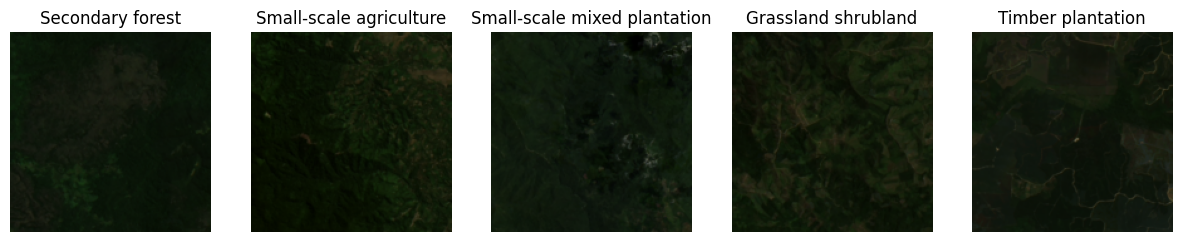

In [92]:
import matplotlib.pyplot as plt
import torch


# Function to visualize a batch of images
def show_images(images, labels, num_images=5, img_type="visible"):
    plt.figure(figsize=(15, 7))

    # Check if images are in a list or not
    if isinstance(images, dict):
        images = images.get(img_type, [])

    for i in range(min(num_images, len(images))):
        img = images[i]

        if isinstance(img, torch.Tensor):  # Convert tensor to numpy if needed
            img = img.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")

    plt.show()


# Get a batch of training data
dataiter = iter(train_loader)
sample_batch = next(dataiter)

# Extract images and labels from the sample batch
visible_images = sample_batch["composite_visible"]
labels = sample_batch["label"]

# Visualize the first few visible images in the batch
show_images(sample_batch, labels, num_images=5, img_type="composite_visible")